In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Data

In [4]:
transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=(0.2), contrast=(0.2)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

In [5]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=transforms)
len(dataset)

2300

In [6]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
train_size = int(0.75 * len(dataset))
val_size = int(len(dataset) - train_size)

train_size, val_size

(1725, 575)

In [9]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [11]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


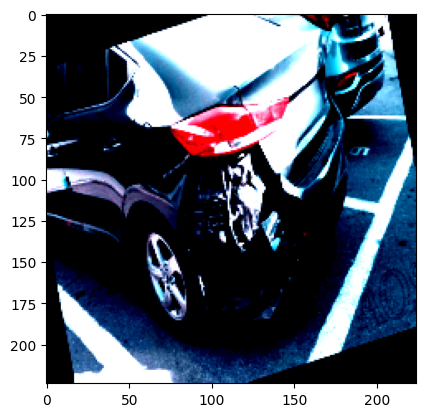

In [13]:
plt.imshow(images[2].permute(1,2,0))
plt.show()

In [14]:
labels[2]

tensor(3)

## Model 1 : CNN

In [15]:
class CarDamageCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
        # In (3,224,224)
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding = 1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Out (32,112,112)
            
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Out (64,56,56)
            
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Out (64,28,28)
            
        nn.Flatten(),
        nn.Linear(64*28*28,512),
        nn.ReLU(),
        nn.Linear(512,num_classes)
        )
        
    def forward(self,x):
        x = self.network(x)
        return x

In [16]:
model = CarDamageCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
images.size(0)

32

In [18]:
def train_model(model, criterion, optimizer, epochs=5):
    model.train()
    start = time.time()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss/ len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Avg. Loss {epoch_loss}")
    
    model.eval()
    with torch.no_grad():
        corrected = 0
        total = 0
        all_labels = []
        all_preds = []
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0) 
            corrected += (preds == labels).sum().item()
            
            print(f"***************Validation_accuracy = {(100 * corrected/total):.2f}*****************")
    end = time.time()
    print(f"Total time taken is {(end - start):.2f}.")
    return all_labels, all_preds

In [58]:
train_model(model, criterion, optimizer, epochs=10)

Epoch 1/10, Avg. Loss 0.9508027213552723
Epoch 2/10, Avg. Loss 0.888104902488598
Epoch 3/10, Avg. Loss 0.8404291246939396
Epoch 4/10, Avg. Loss 0.8392487725313159
Epoch 5/10, Avg. Loss 0.8024941342464392
Epoch 6/10, Avg. Loss 0.7206686161566471
Epoch 7/10, Avg. Loss 0.7280889993474103
Epoch 8/10, Avg. Loss 0.6596310614157415
Epoch 9/10, Avg. Loss 0.6378395243313002
Epoch 10/10, Avg. Loss 0.6073762225413668
***************Validation_accuracy = 71.88*****************
***************Validation_accuracy = 64.06*****************
***************Validation_accuracy = 59.38*****************
***************Validation_accuracy = 59.38*****************
***************Validation_accuracy = 60.00*****************
***************Validation_accuracy = 59.38*****************
***************Validation_accuracy = 57.59*****************
***************Validation_accuracy = 58.98*****************
***************Validation_accuracy = 59.03*****************
***************Validation_accuracy = 60.00********

([np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(5),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(2),
  np.int64(5),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(4),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(5),
  np.int64(0),
  np.int64(2),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64

## Model 2: CNN with Regularization

In [59]:
class CarDamageCNNwithregularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
        # In (3,224,224)
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding = 1, stride=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Out (32,112,112)
            
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Out (64,56,56)
            
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # Out (64,28,28)
            
        nn.Flatten(),
        nn.Linear(64*28*28,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,num_classes)
        )
        
    def forward(self,x):
        x = self.network(x)
        return x

In [61]:
model_reg = CarDamageCNNwithregularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_model(model, criterion, optimizer, epochs=10)

Epoch 1/10, Avg. Loss 0.6744934976964757
Epoch 2/10, Avg. Loss 0.5467532609338346
Epoch 3/10, Avg. Loss 0.4790711139768794
Epoch 4/10, Avg. Loss 0.48281160710514454
Epoch 5/10, Avg. Loss 0.4583624424796173
Epoch 6/10, Avg. Loss 0.42923153745955317
Epoch 7/10, Avg. Loss 0.3887041740141053
Epoch 8/10, Avg. Loss 0.35761603809785153
Epoch 9/10, Avg. Loss 0.36539175052573714
Epoch 10/10, Avg. Loss 0.3380317387028017
***************Validation_accuracy = 59.38*****************
***************Validation_accuracy = 54.69*****************
***************Validation_accuracy = 59.38*****************
***************Validation_accuracy = 59.38*****************
***************Validation_accuracy = 58.75*****************
***************Validation_accuracy = 57.29*****************
***************Validation_accuracy = 58.93*****************
***************Validation_accuracy = 57.42*****************
***************Validation_accuracy = 56.25*****************
***************Validation_accuracy = 56.25***

([np.int64(0),
  np.int64(4),
  np.int64(2),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(3),
  np.int64(4),
  np.int64(3),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(5),
  np.int64(2),
  np.int64(3),
  np.int64(2),
  np.int64(5),
  np.int64(4),
  np.int64(1),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(4),
  np.int64(5),
  np.int64(0),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(5),
  np.int64(2),
  np.int64(0),
  np.int64(3),
  np.int64(5),
  np.int64(0),
  np.int64(5),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(2),
  np.int64(3),
  np.int64(2),
  np.int64

## Model 3: Transfer Learning with EfficientNet

AttributeError: 'generator' object has no attribute 'requires_grad'

In [24]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features,num_classes)
        )
        
    def forward(self,x):
        x = self.model(x)
        return x

In [25]:
model_efficient = CarClassifierEfficientNet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model_efficient.parameters()),lr=0.001)

train_model(model_efficient, criterion, optimizer, epochs=10)

Epoch 1/10, Avg. Loss 1.5068710353409034
Epoch 2/10, Avg. Loss 1.143084830823152
Epoch 3/10, Avg. Loss 1.0345632669200069
Epoch 4/10, Avg. Loss 0.974540767531464
Epoch 5/10, Avg. Loss 0.9256165842387987
Epoch 6/10, Avg. Loss 0.8856930253816687
Epoch 7/10, Avg. Loss 0.8792473362494206
Epoch 8/10, Avg. Loss 0.8552993241600368
Epoch 9/10, Avg. Loss 0.8446780794945316
Epoch 10/10, Avg. Loss 0.8256387051983156
***************Validation_accuracy = 59.38*****************
***************Validation_accuracy = 67.19*****************
***************Validation_accuracy = 65.62*****************
***************Validation_accuracy = 61.72*****************
***************Validation_accuracy = 64.38*****************
***************Validation_accuracy = 65.10*****************
***************Validation_accuracy = 63.84*****************
***************Validation_accuracy = 63.28*****************
***************Validation_accuracy = 64.24*****************
***************Validation_accuracy = 64.69*********

([np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(2),
  np.int64(1),
  np.int64(4),
  np.int64(4),
  np.int64(0),
  np.int64(4),
  np.int64(3),
  np.int64(1),
  np.int64(4),
  np.int64(3),
  np.int64(4),
  np.int64(1),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(4),
  np.int64(2),
  np.int64(3),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(5),
  np.int64(1),
  np.int64(3),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(4),
  np.int64(5),
  np.int64(2),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(5),
  np.int64(1),
  np.int64(1),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(5),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(2),
  np.int64(4),
  np.int64(3),
  np.int64(3),
  np.int64(5),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(3),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(2),
  np.int64(1),
  np.int64

## Model 4: Transfer Learning with ResNet

In [31]:
models.resnet50(weights='DEFAULT')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
class CarDamageResnet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        self.model = models.resnet50(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        in_features = self.model.fc.in_features
        
        self.model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, num_classes)
        )
        
    def forward(self,x):
        x = self.model(x)
        return x

In [38]:
model_resnet = CarDamageResnet(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model_resnet.parameters()), lr=0.001)

train_model(model_resnet, criterion, optimizer, epochs=10)

Epoch 1/10, Avg. Loss 0.8361080156201902
Epoch 2/10, Avg. Loss 0.5115897700233736
Epoch 3/10, Avg. Loss 0.37601956744124926
Epoch 4/10, Avg. Loss 0.29253958190696827
Epoch 5/10, Avg. Loss 0.2275853575139806
Epoch 6/10, Avg. Loss 0.1846894728705503
Epoch 7/10, Avg. Loss 0.1542555404227713
Epoch 8/10, Avg. Loss 0.12050768715747888
Epoch 9/10, Avg. Loss 0.13704323258088982
Epoch 10/10, Avg. Loss 0.1250968622556631
***************Validation_accuracy = 75.00*****************
***************Validation_accuracy = 78.12*****************
***************Validation_accuracy = 76.04*****************
***************Validation_accuracy = 75.78*****************
***************Validation_accuracy = 75.00*****************
***************Validation_accuracy = 75.00*****************
***************Validation_accuracy = 74.11*****************
***************Validation_accuracy = 74.22*****************
***************Validation_accuracy = 73.26*****************
***************Validation_accuracy = 72.50***

([np.int64(0),
  np.int64(2),
  np.int64(0),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(1),
  np.int64(3),
  np.int64(2),
  np.int64(4),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(1),
  np.int64(4),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(1),
  np.int64(4),
  np.int64(0),
  np.int64(5),
  np.int64(2),
  np.int64(2),
  np.int64(5),
  np.int64(4),
  np.int64(1),
  np.int64(3),
  np.int64(4),
  np.int64(0),
  np.int64(0),
  np.int64(4),
  np.int64(4),
  np.int64(4),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(5),
  np.int64(1),
  np.int64(5),
  np.int64(3),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(2),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(5),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(4),
  np.int64(5),
  np.int64

In [45]:
class CarDamageResnet_hyper(nn.Module):
    def __init__(self,num_classes,dropout_rate):
        super().__init__()
        
        self.model = models.resnet50(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        in_features = self.model.fc.in_features
        
        self.model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(in_features, num_classes)
        )
        
    def forward(self,x):
        x = self.model(x)
        return x

In [ ]:
import optuna
# 3. Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('lr',0.0000001, 0.01, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    # Model, loss, optimizer
    model = CarDamageResnet_hyper(num_classes = num_classes,dropout_rate = dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p:p.requires_grad,model_resnet.parameters()), lr=0.001)



    # Training loop
    epochs = 3
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
    

    # Validation accuracy
    
    model.eval()
    with torch.no_grad():
        corrected = 0
        total = 0
        all_labels = []
        all_preds = []
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0) 
            corrected += (preds == labels).sum().item()
            
            
    return all_labels, all_preds

# 4. Run the Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# 5. Print the best hyperparameters
print("Best hyperparameters found:")
print(study.best_params)

[I 2025-07-07 23:14:42,959] A new study created in memory with name: no-name-a1e2abe1-e0e6-47e6-b544-63b3da7a3d59
[W 2025-07-07 23:18:13,175] Trial 0 failed with parameters: {'lr': 1.0588762904200655e-07, 'dropout_rate': 0.3893649784414924} because of the following error: The value [np.int64(1), np.int64(4), np.int64(3), np.int64(0), np.int64(1), np.int64(4), np.int64(3), np.int64(0), np.int64(5), np.int64(1), np.int64(4), np.int64(1), np.int64(0), np.int64(4), np.int64(4), np.int64(2), np.int64(1), np.int64(3), np.int64(5), np.int64(2), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(5), np.int64(4), np.int64(4), np.int64(1), np.int64(1), np.int64(3), np.int64(2), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(5), np.int64(0), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(2), np.int64(5), np.int64(3), np.int64(1), np.int64(2), np.int64(0), np.int64(4), np.int64(2), np.int64(0), np.int64(1), np.int64(3), np.int64(2), n

[W 2025-07-07 23:21:39,210] Trial 1 failed with parameters: {'lr': 1.4322063870111742e-05, 'dropout_rate': 0.2991935862348164} because of the following error: The value [np.int64(3), np.int64(2), np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(4), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(3), np.int64(4), np.int64(3), np.int64(3), np.int64(0), np.int64(2), np.int64(5), np.int64(1), np.int64(3), np.int64(4), np.int64(2), np.int64(3), np.int64(3), np.int64(1), np.int64(4), np.int64(2), np.int64(1), np.int64(5), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(3), np.int64(2), np.int64(3), np.int64(0), np.int64(0), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(2), np.int64(0), np.int64(3), np.int64(1), np.int64(3), np.int64(2), np.int64(0), np.int64(3), np.int64(1), np.int64(1), np.int64(4), np.int64(4), np.int64(2), np.int64(2), np.int64(4)

[W 2025-07-07 23:25:03,126] Trial 2 failed with parameters: {'lr': 5.370926341691958e-06, 'dropout_rate': 0.618606265783674} because of the following error: The value [np.int64(2), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(2), np.int64(4), np.int64(1), np.int64(4), np.int64(2), np.int64(0), np.int64(3), np.int64(5), np.int64(3), np.int64(4), np.int64(1), np.int64(3), np.int64(4), np.int64(1), np.int64(3), np.int64(0), np.int64(1), np.int64(5), np.int64(1), np.int64(3), np.int64(0), np.int64(0), np.int64(5), np.int64(4), np.int64(0), np.int64(1), np.int64(3), np.int64(0), np.int64(2), np.int64(5), np.int64(2), np.int64(2), np.int64(0), np.int64(4), np.int64(3), np.int64(4), np.int64(1), np.int64(0), np.int64(1), np.int64(4), np.int64(2), np.int64(1), np.int64(2), np.int64(3), np.int64(1), np.int64(3), np.int64(3), np.int64(2), np.int64(4), np.int64(2), np.int64(3), np.int64(5), np.int64(4), np.int64(4), np.int64(5), np.int64(1), np.int64(0), np.int64(3), np.int64(0), 

[W 2025-07-07 23:28:43,123] Trial 3 failed with parameters: {'lr': 1.1105169656502534e-05, 'dropout_rate': 0.589166354114985} because of the following error: The value [np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(5), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(3), np.int64(4), np.int64(5), np.int64(2), np.int64(5), np.int64(3), np.int64(5), np.int64(2), np.int64(5), np.int64(4), np.int64(0), np.int64(3), np.int64(0), np.int64(2), np.int64(4), np.int64(1), np.int64(5), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(0), np.int64(0), np.int64(5), np.int64(1), np.int64(0), np.int64(4), np.int64(5), np.int64(2), np.int64(1), np.int64(2), np.int64(2), np.int64(5), np.int64(5), np.int64(2), np.int64(3), np.int64(2), np.int64(2), np.int64(2), np.int64(5), np.int64(4), np.int64(4), np.int64(2), np.int64(5), np.int64(1), np.int64(3), np.int64(0),

[W 2025-07-07 23:32:29,602] Trial 4 failed with parameters: {'lr': 1.8395756287163387e-05, 'dropout_rate': 0.29954706381318363} because of the following error: The value [np.int64(2), np.int64(5), np.int64(1), np.int64(5), np.int64(0), np.int64(2), np.int64(3), np.int64(2), np.int64(4), np.int64(2), np.int64(2), np.int64(2), np.int64(4), np.int64(0), np.int64(5), np.int64(1), np.int64(0), np.int64(2), np.int64(2), np.int64(4), np.int64(2), np.int64(0), np.int64(2), np.int64(3), np.int64(5), np.int64(2), np.int64(4), np.int64(0), np.int64(2), np.int64(2), np.int64(3), np.int64(4), np.int64(0), np.int64(4), np.int64(1), np.int64(2), np.int64(4), np.int64(1), np.int64(1), np.int64(5), np.int64(1), np.int64(2), np.int64(5), np.int64(2), np.int64(1), np.int64(1), np.int64(5), np.int64(1), np.int64(0), np.int64(3), np.int64(0), np.int64(4), np.int64(2), np.int64(1), np.int64(0), np.int64(3), np.int64(3), np.int64(3), np.int64(4), np.int64(4), np.int64(0), np.int64(2), np.int64(0), np.int64(2

[W 2025-07-07 23:36:03,699] Trial 5 failed with parameters: {'lr': 5.251347121342537e-06, 'dropout_rate': 0.2275952903322387} because of the following error: The value [np.int64(4), np.int64(5), np.int64(2), np.int64(1), np.int64(4), np.int64(5), np.int64(3), np.int64(2), np.int64(3), np.int64(2), np.int64(4), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(5), np.int64(3), np.int64(4), np.int64(3), np.int64(5), np.int64(1), np.int64(0), np.int64(2), np.int64(0), np.int64(5), np.int64(0), np.int64(5), np.int64(3), np.int64(1), np.int64(4), np.int64(3), np.int64(1), np.int64(1), np.int64(3), np.int64(1), np.int64(2), np.int64(5), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(3), np.int64(1), np.int64(2), np.int64(5), np.int64(2), np.int64(4), np.int64(2), np.int64(2), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(1), np.int64(1), np.int64(1), np.int64(4), np.int64(1), np.int64(4), np.int64(5), np.int64(2), np.int64(1), np.int64(4),

[W 2025-07-07 23:39:28,264] Trial 6 failed with parameters: {'lr': 0.005725772603104659, 'dropout_rate': 0.3374434900420584} because of the following error: The value [np.int64(4), np.int64(0), np.int64(2), np.int64(5), np.int64(2), np.int64(4), np.int64(1), np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(4), np.int64(2), np.int64(5), np.int64(2), np.int64(0), np.int64(5), np.int64(1), np.int64(3), np.int64(3), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(3), np.int64(4), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(0), np.int64(2), np.int64(0), np.int64(1), np.int64(3), np.int64(3), np.int64(1), np.int64(5), np.int64(2), np.int64(2), np.int64(4), np.int64(1), np.int64(5), np.int64(1), np.int64(4), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(5), np.int64(3), np.int64(3), np.int64(3), np.int64(2), np.int64(1), np.int64(2), np.int64(5), np.int64(0), np.int64(0), np.int64(3), np.int64(1), np.int64(5), 

[W 2025-07-07 23:42:52,639] Trial 7 failed with parameters: {'lr': 0.009355963752453213, 'dropout_rate': 0.38897792887088856} because of the following error: The value [np.int64(2), np.int64(5), np.int64(0), np.int64(3), np.int64(1), np.int64(0), np.int64(5), np.int64(4), np.int64(4), np.int64(2), np.int64(0), np.int64(1), np.int64(4), np.int64(3), np.int64(4), np.int64(2), np.int64(2), np.int64(3), np.int64(5), np.int64(2), np.int64(2), np.int64(3), np.int64(0), np.int64(0), np.int64(5), np.int64(0), np.int64(0), np.int64(3), np.int64(4), np.int64(0), np.int64(4), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(5), np.int64(4), np.int64(0), np.int64(0), np.int64(5), np.int64(3), np.int64(5), np.int64(3), np.int64(3), np.int64(2), np.int64(1), np.int64(3), np.int64(2), np.int64(2), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(3), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(2),

[W 2025-07-07 23:46:12,213] Trial 8 failed with parameters: {'lr': 2.5808979522240814e-07, 'dropout_rate': 0.5547186744708836} because of the following error: The value [np.int64(1), np.int64(1), np.int64(3), np.int64(2), np.int64(0), np.int64(1), np.int64(5), np.int64(2), np.int64(2), np.int64(5), np.int64(2), np.int64(4), np.int64(0), np.int64(4), np.int64(0), np.int64(2), np.int64(2), np.int64(1), np.int64(0), np.int64(3), np.int64(0), np.int64(3), np.int64(4), np.int64(2), np.int64(4), np.int64(0), np.int64(0), np.int64(5), np.int64(2), np.int64(5), np.int64(4), np.int64(2), np.int64(1), np.int64(3), np.int64(0), np.int64(5), np.int64(5), np.int64(1), np.int64(5), np.int64(3), np.int64(0), np.int64(1), np.int64(1), np.int64(3), np.int64(1), np.int64(5), np.int64(0), np.int64(0), np.int64(0), np.int64(4), np.int64(2), np.int64(1), np.int64(3), np.int64(5), np.int64(4), np.int64(1), np.int64(2), np.int64(1), np.int64(5), np.int64(2), np.int64(3), np.int64(1), np.int64(3), np.int64(1)

[W 2025-07-07 23:49:30,836] Trial 9 failed with parameters: {'lr': 1.9878013430532637e-06, 'dropout_rate': 0.613939930710266} because of the following error: The value [np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(4), np.int64(3), np.int64(2), np.int64(0), np.int64(0), np.int64(3), np.int64(5), np.int64(0), np.int64(5), np.int64(4), np.int64(0), np.int64(1), np.int64(0), np.int64(3), np.int64(5), np.int64(0), np.int64(2), np.int64(2), np.int64(1), np.int64(0), np.int64(4), np.int64(3), np.int64(1), np.int64(1), np.int64(0), np.int64(3), np.int64(4), np.int64(2), np.int64(5), np.int64(4), np.int64(0), np.int64(1), np.int64(1), np.int64(3), np.int64(3), np.int64(2), np.int64(5), np.int64(4), np.int64(1), np.int64(1), np.int64(3), np.int64(4), np.int64(4), np.int64(3), np.int64(0), np.int64(2), np.int64(1), np.int64(4), np.int64(3), np.int64(3), np.int64(2), np.int64(2), np.int64(5), np.int64(1), np.int64(4), np.int64(2), np.int64(2), np.int64(4), np.int64(0), np.int64(0),

[W 2025-07-07 23:52:50,969] Trial 10 failed with parameters: {'lr': 9.535084776068507e-07, 'dropout_rate': 0.35341338222043595} because of the following error: The value [np.int64(1), np.int64(0), np.int64(1), np.int64(4), np.int64(5), np.int64(0), np.int64(3), np.int64(0), np.int64(5), np.int64(2), np.int64(3), np.int64(3), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(3), np.int64(4), np.int64(3), np.int64(2), np.int64(0), np.int64(1), np.int64(5), np.int64(0), np.int64(2), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(3), np.int64(2), np.int64(5), np.int64(1), np.int64(2), np.int64(4), np.int64(1), np.int64(0), np.int64(4), np.int64(0), np.int64(5), np.int64(2), np.int64(3), np.int64(3), np.int64(2), np.int64(1), np.int64(5), np.int64(3), np.int64(2), np.int64(0), np.int64(3), np.int64(3), np.int64(1), np.int64(4), np.int64(0), np.int64(1), np.int64(1), np.int64(4

[W 2025-07-07 23:56:11,490] Trial 11 failed with parameters: {'lr': 2.0111423291633374e-06, 'dropout_rate': 0.3795342786853396} because of the following error: The value [np.int64(3), np.int64(0), np.int64(2), np.int64(2), np.int64(2), np.int64(5), np.int64(5), np.int64(2), np.int64(0), np.int64(1), np.int64(4), np.int64(3), np.int64(5), np.int64(0), np.int64(1), np.int64(5), np.int64(2), np.int64(0), np.int64(3), np.int64(2), np.int64(5), np.int64(5), np.int64(3), np.int64(2), np.int64(3), np.int64(2), np.int64(2), np.int64(3), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(3), np.int64(0), np.int64(2), np.int64(2), np.int64(2), np.int64(4), np.int64(2), np.int64(2), np.int64(0), np.int64(2), np.int64(1), np.int64(5), np.int64(4), np.int64(2), np.int64(1), np.int64(4), np.int64(3), np.int64(0), np.int64(3), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(2), np.int64(5), np.int64(1), np.int64(2

[W 2025-07-07 23:59:30,992] Trial 12 failed with parameters: {'lr': 5.341354048583049e-07, 'dropout_rate': 0.2340103536409972} because of the following error: The value [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(0), np.int64(0), np.int64(3), np.int64(3), np.int64(1), np.int64(5), np.int64(2), np.int64(3), np.int64(1), np.int64(4), np.int64(4), np.int64(0), np.int64(4), np.int64(3), np.int64(0), np.int64(4), np.int64(2), np.int64(2), np.int64(4), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(2), np.int64(5), np.int64(1), np.int64(2), np.int64(4), np.int64(0), np.int64(0), np.int64(4), np.int64(2), np.int64(0), np.int64(3), np.int64(2), np.int64(1), np.int64(4), np.int64(0), np.int64(3), np.int64(0), np.int64(4), np.int64(2), np.int64(5), np.int64(0), np.int64(0), np.int64(1), np.int64(2), np.int64(0), np.int64(0), np.int64(5), np.int64(5), np.int64(0), np.int64(1), np.int64(5), np.int64(1), np.int64(0), np.int64(2), np.int64(3), np.int64(2), np.int64(5)

[W 2025-07-08 00:02:46,228] Trial 13 failed with parameters: {'lr': 2.0467856829628518e-05, 'dropout_rate': 0.31204851368024067} because of the following error: The value [np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(5), np.int64(4), np.int64(5), np.int64(2), np.int64(1), np.int64(4), np.int64(1), np.int64(0), np.int64(5), np.int64(4), np.int64(4), np.int64(0), np.int64(3), np.int64(0), np.int64(2), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(2), np.int64(2), np.int64(0), np.int64(2), np.int64(1), np.int64(0), np.int64(2), np.int64(2), np.int64(0), np.int64(2), np.int64(0), np.int64(1), np.int64(0), np.int64(4), np.int64(2), np.int64(0), np.int64(1), np.int64(5), np.int64(3), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(4), np.int64(4), np.int64(1), np.int64(3), np.int64(2), np.int64(1), np.int64(4), np.int64(0), np.int64(0), np.int64(1), np.int64(5), np.int64(0), np.int64(0), np.int64(4), np.int64(

[W 2025-07-08 00:05:36,351] Trial 14 failed with parameters: {'lr': 9.117362404616536e-05, 'dropout_rate': 0.31918828145894446} because of the following error: The value [np.int64(5), np.int64(1), np.int64(5), np.int64(5), np.int64(1), np.int64(2), np.int64(1), np.int64(5), np.int64(2), np.int64(0), np.int64(2), np.int64(5), np.int64(4), np.int64(2), np.int64(5), np.int64(0), np.int64(5), np.int64(5), np.int64(0), np.int64(0), np.int64(1), np.int64(5), np.int64(2), np.int64(0), np.int64(0), np.int64(4), np.int64(3), np.int64(1), np.int64(4), np.int64(1), np.int64(2), np.int64(0), np.int64(0), np.int64(2), np.int64(3), np.int64(0), np.int64(3), np.int64(3), np.int64(0), np.int64(3), np.int64(1), np.int64(1), np.int64(4), np.int64(1), np.int64(0), np.int64(4), np.int64(5), np.int64(4), np.int64(3), np.int64(0), np.int64(3), np.int64(0), np.int64(2), np.int64(2), np.int64(2), np.int64(5), np.int64(0), np.int64(1), np.int64(5), np.int64(1), np.int64(4), np.int64(5), np.int64(0), np.int64(2

## Hyperparameter model

In [19]:
class CarDamageResnet_hyper(nn.Module):
    def __init__(self,num_classes,dropout_rate):
        super().__init__()
        
        self.model = models.resnet50(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        in_features = self.model.fc.in_features
        
        self.model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(in_features, num_classes)
        )
        
    def forward(self,x):
        x = self.model(x)
        return x

In [22]:
model = CarDamageResnet_hyper(num_classes = num_classes,dropout_rate = 0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model.parameters()), lr=0.003)

labels,preds = train_model(model, criterion, optimizer, epochs=5)

Epoch 1/5, Avg. Loss 0.8822743230626203
Epoch 2/5, Avg. Loss 0.5404702487544737
Epoch 3/5, Avg. Loss 0.3896661653380463
Epoch 4/5, Avg. Loss 0.3086078603025796
Epoch 5/5, Avg. Loss 0.21898051738739013
***************Validation_accuracy = 87.50*****************
***************Validation_accuracy = 81.25*****************
***************Validation_accuracy = 80.21*****************
***************Validation_accuracy = 78.91*****************
***************Validation_accuracy = 77.50*****************
***************Validation_accuracy = 77.60*****************
***************Validation_accuracy = 79.46*****************
***************Validation_accuracy = 78.12*****************
***************Validation_accuracy = 78.12*****************
***************Validation_accuracy = 78.12*****************
***************Validation_accuracy = 78.12*****************
***************Validation_accuracy = 78.39*****************
***************Validation_accuracy = 77.88*****************
***************Vali

In [23]:
labels[:5], preds[:5]

([np.int64(0), np.int64(0), np.int64(3), np.int64(3), np.int64(2)],
 [np.int64(0), np.int64(0), np.int64(4), np.int64(4), np.int64(2)])

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [25]:
print(classification_reportreportreportreport_report(labels, preds))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       111
           1       0.72      0.81      0.76       115
           2       0.98      0.79      0.87       117
           3       0.92      0.66      0.77        82
           4       0.63      0.81      0.71        72
           5       0.79      0.79      0.79        78

    accuracy                           0.79       575
   macro avg       0.80      0.79      0.79       575
weighted avg       0.81      0.79      0.80       575



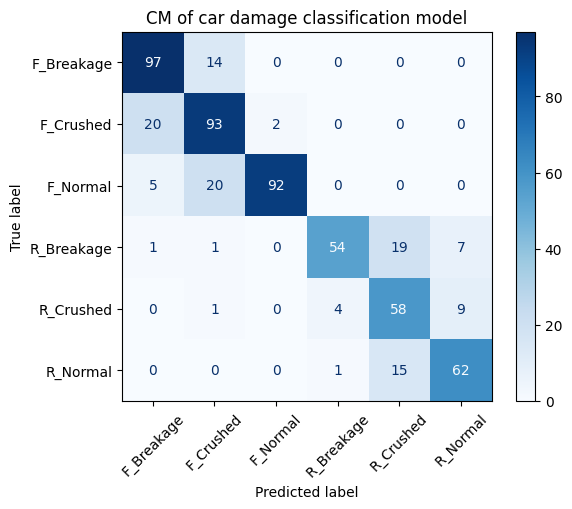

In [29]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dataset.classes)
disp.plot(cmap='Blues')
plt.xticks(rotation=45)
plt.title("CM of car damage classification model")
plt.show()

In [30]:
torch.save(model.state_dict(), 'car_damage_model.pth')